In [3]:
import os 
import json 
from collections import defaultdict
from typing import List, Dict, Any
import re

papers = [11, 13, 14, 15, 16, 17, 18, 19, 20, 100] # read the annotated overlapping paper IDs 
overlap_path = "../../annotated_data/citation_annotations/annotations/overlap"
ann_path = "../../annotated_data/citation_annotations/annotations"
text_folder = "../../to_annotate"
total_data = []

for files in os.listdir(overlap_path):
    if files.endswith(".json"):
        file_path = os.path.join(overlap_path, files)
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for item in data:
            filename = item["file"]
            with open(os.path.join(text_folder, filename), "r", encoding="utf-8") as f:
                full_text = f.read()
            total_data.append({"file": item["file"], "start": item["start"], "end": item["end"], "label": item["label"], 'text': item['text'], 'full_text': full_text.split("References")[0]})
    

for ann in os.listdir(ann_path):
    print("Processing folder:", ann)
    for file in os.listdir(os.path.join(ann_path, ann)):
        if file.endswith(".json") and int(file.split("_")[1].split(".")[0]) not in papers:    
            file_path = os.path.join(ann_path, ann, file)
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            for item in data:
                filename = item["file"]
            with open(os.path.join(text_folder, filename), "r", encoding="utf-8") as f:
                full_text = f.read()
            total_data.append({"file": item["file"], "start": item["start"], "end": item["end"], "label": item["label"], 'text': item['text'], 'full_text': full_text.split("References")[0]})
        
with open("../../annotated_data/goldset_sorted.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for item in data:
    for label in item:
        filename = label["filename"]
        with open(os.path.join(text_folder, filename), "r", encoding="utf-8") as f:
            full_text = f.read()
        total_data.append({"file": label["filename"], "start": label["start"], "end": label["end"], "label": label["label"], 'text': label['text'], 'full_text': full_text.split("References")[0]})


_PAPER_NUM_RE = re.compile(r"paper_(\d+)\.txt")

def _paper_key(filename: str) -> int:
    """
    Extract numeric index from 'paper_n.txt' for sorting.
    Falls back to +inf if pattern doesn't match.
    """
    m = _PAPER_NUM_RE.match(filename)
    return int(m.group(1)) if m else float("inf")

def group_spans_by_file(records: List[Dict[str, Any]]):
    grouped = defaultdict(list)

    for r in records:
        grouped[r["file"]].append({
            "start": int(r["start"]),
            "end": int(r["end"]),
            "label": r["label"],
            "text": r['text'],
            "full_text": r['full_text']
        })

    # Sort by numeric paper index
    sorted_grouped = dict(
        sorted(grouped.items(), key=lambda item: _paper_key(item[0]))
    )

    return sorted_grouped
total_data = group_spans_by_file(total_data)

Processing folder: Iman
Processing folder: Ekaterina
Processing folder: overlap
Processing folder: Iraa
Processing folder: Ed


In [4]:
#train and eval split
import random
import re
from typing import Dict, List, Any, Tuple
import json 

PaperData = Dict[str, List[Dict[str, Any]]]

_PAPER_RE = re.compile(r"paper_(\d+)\.txt$")

def paper_num(name: str) -> int:
    m = _PAPER_RE.search(name)
    return int(m.group(1)) if m else 10**18  # unknowns go to end

def split_by_paper(
    data_by_paper: PaperData,
    train_ratio: float = 0.5,
    dev_ratio: float = 0.5,
    eval_ratio: float = 0,
    seed: int = 42,
) -> Tuple[PaperData, PaperData, PaperData]:
    assert abs((train_ratio + dev_ratio + eval_ratio) - 1.0) < 1e-9

    keys = sorted(data_by_paper.keys(), key=paper_num)

    rng = random.Random(seed)
    rng.shuffle(keys)

    n = len(keys)
    n_train = int(n * train_ratio)
    n_dev = int(n * dev_ratio)
    # eval gets the remainder to avoid rounding issues
    train_keys = keys[:n_train]
    dev_keys = keys[n_train:n_train + n_dev]
    eval_keys = keys[n_train + n_dev:]

    train = {k: data_by_paper[k] for k in train_keys}
    dev = {k: data_by_paper[k] for k in dev_keys}
    eval_ = {k: data_by_paper[k] for k in eval_keys}

    return train, dev, eval_

eval_data, for_synth_data, _ = split_by_paper(total_data)

def save_split(split: dict, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(split, f, ensure_ascii=False, indent=2)

save_split(eval_data, "for_eval.json")
save_split(for_synth_data, "for_synth_sampling.json")

In [5]:
import json 

with open("for_synth_sampling.json", 'r') as f:
    for_synth_data = json.load(f)

with open("for_eval.json", 'r') as f:
    for_eval = json.load(f)

total_data = for_synth_data | for_eval
len(total_data)

88

### Real samples profiling:
- length of spans/token count
- average position in the document -> variance/std
- semantic similarity

In [6]:
coherence_samples = []
unsupp_claim = []
lack_synth = []
format = []

for ann in total_data:
    for item in total_data[ann]: 
        if item['label'].lower() == 'coherence':
            coherence_samples.append(item)
        elif item['label'].lower() == 'unsupported claim':
            unsupp_claim.append(item)
        elif item['label'].lower() == 'lacks synthesis':
            lack_synth.append(item)
        elif item['label'].lower() == 'format':
            format.append(item)

print("Annotated data stats:")
print(f"{len(coherence_samples)} Coherence samples")
print(f"{len(unsupp_claim)} Unsupported claim samples")
print(f"{len(lack_synth)} Lacks Synthesis samples")
print(f"{len(format)} Format samples")

Annotated data stats:
24 Coherence samples
104 Unsupported claim samples
27 Lacks Synthesis samples
32 Format samples


In [7]:
import numpy as np

def center_ratio(doc, start, end): # computes where a span is in the document producing a number between 0 t0 1, where 0 = start and 1 = end
    if len(doc) == 0:
        return None
    if start is None or end is None:
        return None
    if start < 0 or end < 0:
        return None

    center = (start + end) / 2.0
    return center / len(doc) # ratio of center position to length of document


def position_stats(samples, doc_key="full_text", start_key="start", end_key="end"):
    positions = [] # center positions

    for s in samples:
        r = center_ratio(s[doc_key], s[start_key], s[end_key])
        if r is None:
            continue
        positions.append(r)


    out = {
        "count": len(positions),
        "mean": round(np.mean(positions), 4),           # mean center position
        "median": round(np.median(positions), 4),       # median center position
        "std": round(np.std(positions), 4),             # standard dev center position
        "variance": round((np.std(positions)**2), 4),
        "p10": round(np.percentile(positions, 10), 4),  
        "p25": round(np.percentile(positions, 25), 4),
        "p75": round(np.percentile(positions, 75), 4),
        "p90": round(np.percentile(positions, 90), 4),
    }

    return out

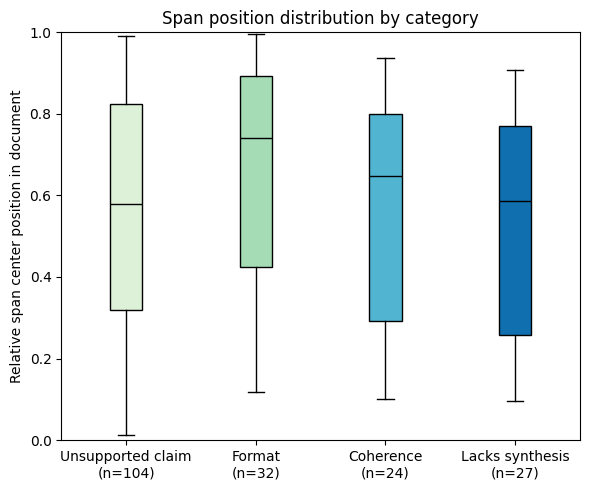

Saved: results/real/real_all_categories_center_pos_box.png


In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np

def position_box(samples, doc_key="full_text", start_key="start", end_key="end"):
    """
    Returns raw relative span center positions in [0, 1] for box plot.
    """
    positions = []
    for s in samples:
        r = center_ratio(s[doc_key], s[start_key], s[end_key])
        if r is None:
            continue
        positions.append(r)

    return {"positions": positions, "count": len(positions)}


def plot_position_boxplot_all(
    pos_by_group,
    folder,
    *,
    top_k=None,
    group_name="Group",
    title="Span position distribution (all groups)",
    filename="all_groups_center_pos_box.png",
):
    groups = list(pos_by_group.keys())

    if top_k is not None:
        groups = sorted(
            groups,
            key=lambda g: pos_by_group[g].get("count", 0),
            reverse=True
        )[:top_k]

    data = []
    labels = []
    counts = []

    for g in groups:
        vals = pos_by_group[g].get("positions", [])
        if not vals:
            print(f"Skipping {group_name}={g}: no data")
            continue
        data.append(vals)
        labels.append(g)
        counts.append(pos_by_group[g].get("count", len(vals)))

    if not data:
        print("No groups had data; nothing to plot.")
        return

    xticks = [f"{lab}\n(n={n})" for lab, n in zip(labels, counts)]

    # --- colormap ---
    cmap = plt.get_cmap("GnBu")
    colors = cmap(np.linspace(0.15, 0.85, len(data)))

    # --------- CHANGED: smaller figure width ----------
    plt.figure(figsize=(max(6, 1.2 * len(data)), 5))

    bp = plt.boxplot(
        data,
        vert=True,
        widths=0.25,
        showfliers=True,
        patch_artist=True,
        medianprops=dict(color="black"),
    )

    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")

    plt.title(title)
    plt.ylabel("Relative span center position in document")
    plt.ylim(0, 1)
    plt.xticks(range(1, len(xticks) + 1), xticks, rotation=0)

    plt.tight_layout()
    os.makedirs(f"results/{folder}", exist_ok=True)
    out_path = f"results/{folder}/{filename}"
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")


# ---- usage ----
categories = {
    "Unsupported claim": unsupp_claim,
    "Format": format,
    "Coherence": coherence_samples,
    "Lacks synthesis": lack_synth,
}

stats_per_category = {}
pos = {}

for category in categories:
    stats_per_category[category] = position_stats(categories[category])
    pos[category] = position_box(categories[category])

plot_position_boxplot_all(
    pos,
    group_name="Category",
    folder="real",
    title="Span position distribution by category",
    filename="real_all_categories_center_pos_box.png",
)


In [9]:
import re
import numpy as np

# very simple token/word counting
def count_words(text):
    return len(re.findall(r"\b\w+\b", text))

def count_tokens(text):
    # rough token count: words + punctuation
    return len(re.findall(r"\w+|[^\w\s]", text))

def span_length_stats(samples, span_key="text"):
    word_counts = []
    token_counts = []

    for s in samples:
        span = s[span_key]

        word_counts.append(count_words(span))
        token_counts.append(count_tokens(span))

    wc = np.array(word_counts)
    tc = np.array(token_counts)

    return {
        "lengths": word_counts,
        "count": len(wc),
        "words_mean": round(wc.mean(), 4),
        "words_median": round(np.median(wc), 4),
        "words_std": round(wc.std(), 4) ,
        "tokens_mean": round(tc.mean(), 4),
        "tokens_median": round(np.median(tc), 4),
        "tokens_std": round(tc.std(), 4),
    }
    


In [10]:
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_span_length_boxplot_all(
    length_by_category,
    folder,
    title="Span length distribution by category",
    ylabel="Number of words per span",
    filename="span_length_boxplot.png",
):
    categories = list(length_by_category.keys())

    data = []
    labels = []
    counts = []

    for cat in categories:
        vals = length_by_category[cat]["lengths"]
        if not vals:
            continue
        data.append(vals)
        labels.append(cat)
        counts.append(length_by_category[cat]["count"])

    xticks = [f"{lab}\n(n={n})" for lab, n in zip(labels, counts)]

    cmap = plt.get_cmap("GnBu")
    colors = cmap(np.linspace(0.15, 0.85, len(data)))

    plt.figure(figsize=(max(6, 1.2 * len(data)), 5))

    bp = plt.boxplot(
        data,
        widths=0.25,
        showfliers=True,
        patch_artist=True,
        medianprops=dict(color="black"),
    )

    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(range(1, len(xticks) + 1), xticks)
    plt.tight_layout()

    os.makedirs(f"results/{folder}", exist_ok=True)
    out_path = f"results/{folder}/{filename}"
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()

    print(f"Saved: {out_path}")


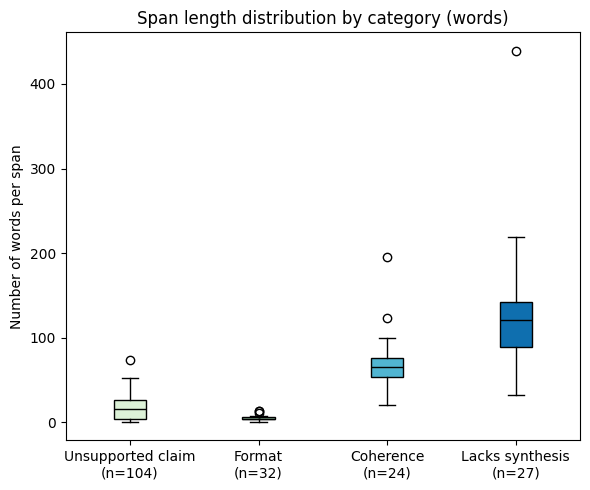

Saved: results/real/real_span_length_box.png


In [11]:
real_length_per_category = {}

for category in categories:
   real_length_per_category[category] = span_length_stats(categories[category])

plot_span_length_boxplot_all(
    real_length_per_category,
    folder="real",
    title="Span length distribution by category (words)",
    ylabel="Number of words per span",
    filename="real_span_length_box.png",
)

In [12]:
filename = "real_word_count.json"
with open(f"results/real/{filename}", 'w') as f:
    json.dump(real_length_per_category, f, indent=2)

### Synthetic data

In [14]:
path ="synthetic_samples.json"

categories = ['lacks_synthesis', 'unsupported_claim', 'format', 'coherence']

with open(path, 'r') as f:
    synth_data = json.load(f)

In [15]:
categories = ['Unsupported claim', 'Format', 'Coherence', 'Lacks synthesis']

print("Annotated data stats:")
for category in categories:
    print(f"{len(synth_data[category])} {category} samples")


Annotated data stats:
1000 Unsupported claim samples
1000 Format samples
500 Coherence samples
500 Lacks synthesis samples


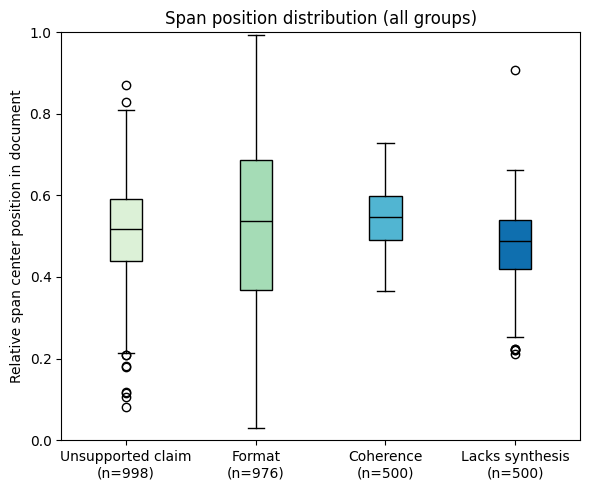

Saved: results/synth/synth_all_categories_center_pos_box.png


In [16]:
categories = ['Unsupported claim', 'Format', 'Coherence', 'Lacks synthesis']
stats_per_category = {}
hists = {}

for category in categories:
    stats_per_category[category] = position_stats(synth_data[category], doc_key='document')
    hists[category] = position_box(synth_data[category], doc_key='document')

plot_position_boxplot_all(hists, group_name='Category', folder='synth', filename="synth_all_categories_center_pos_box.png")

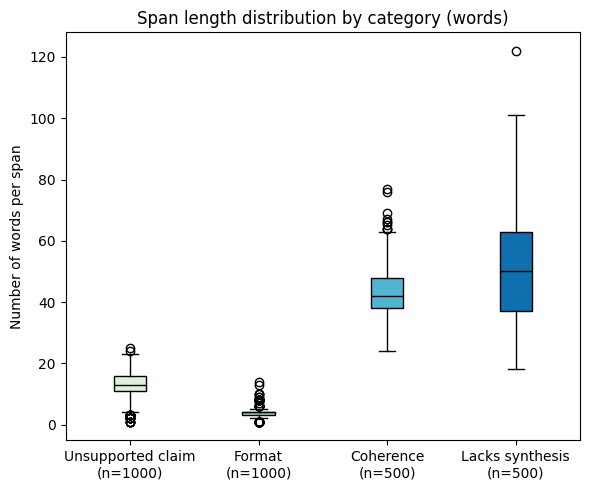

Saved: results/synth/synth_span_length_box.png


In [17]:
synth_length_per_category = {}

for category in categories:
   synth_length_per_category[category] = span_length_stats(synth_data[category], span_key='span')

plot_span_length_boxplot_all(
    synth_length_per_category,
    folder="synth",
    title="Span length distribution by category (words)",
    ylabel="Number of words per span",
    filename="synth_span_length_box.png",
)

In [18]:
filename = "synth_word_count.json"
with open(f"results/synth/{filename}", 'w') as f:
    json.dump(synth_length_per_category, f, indent=2)